In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score,
                             precision_score, recall_score, confusion_matrix,
                             log_loss, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score, precision_recall_curve, auc,
                             DetCurveDisplay, ConfusionMatrixDisplay, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from scipy.stats import chi2_contingency

In [2]:
# loading data sets
df_train = pd.read_csv('train.csv', delimiter = ';')
df_test = pd.read_csv('test.csv', delimiter = ';')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [5]:
print(f"Training Set NaNs\n{df_train.isnull().sum()}")
print(f"Test Set NaNs\n{df_test.isnull().sum()}") # checking for NaN and nulls

Training Set NaNs
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Test Set NaNs
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [6]:
# checking for 'unknown' values in categorical columns in training set
for col in df_train.columns:
    if df_train[col].dtype == 'object':
        unknown_count = (df_train[col] == 'unknown').sum()
        print(f"{col}: {unknown_count}")


job: 288
marital: 0
education: 1857
default: 0
housing: 0
loan: 0
contact: 13020
month: 0
poutcome: 36959
y: 0


In [7]:
# checking for 'unknown' values in categorical columns in test set
for col in df_test.columns:
    if df_test[col].dtype == 'object':
        unknown_count = (df_test[col] == 'unknown').sum()
        print(f"{col}: {unknown_count}")

job: 38
marital: 0
education: 187
default: 0
housing: 0
loan: 0
contact: 1324
month: 0
poutcome: 3705
y: 0


In [8]:
# exploring class distribution of dependent variable
dic = {'no': 0, 'yes': 1} # creating binary dictionary for response variable

df_train['y'] = df_train['y'].map(dic)
df_test['y'] = df_test['y'].map(dic)

In [ ]:
print(f"Mean of training set response variable classes {df_train['y'].mean()}")

Mean of training set response variable classes 0.11698480458295547


In [10]:
print(f"Mean of test set response variable classes {df_test['y'].mean()}")

Mean of test set response variable classes 0.11523999115239991


In [11]:

contingency_table = pd.crosstab(df_train['job'], df_train['y']) # creating contingency table
print(contingency_table)

y                 0     1
job                      
admin.         4540   631
blue-collar    9024   708
entrepreneur   1364   123
housemaid      1131   109
management     8157  1301
retired        1748   516
self-employed  1392   187
services       3785   369
student         669   269
technician     6757   840
unemployed     1101   202
unknown         254    34


In [12]:
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"chi-squared statistic {chi2}")
print(f"p-value {p_value}")
print(f"df {dof}")

chi-squared statistic 836.1054877471965
p-value 3.337121944935502e-172
df 11


- Careers with above average conversion rates:
    - Students **28.7%**
    - Retired **22.8%**

- Careers with below average conversion rates:
    - Blue-collar **7.3%**
    - Entrepreneur **8.3%**

- p-value < 0.05 so reject the null that career type doesn't influence responding well to campaign

**Career type and responding positively to the campaign are dependent**

The chi-squared test (χ² = 836.11, p < 0.001) provides overwhelming evidence that job type and subscription decisions are strongly related. This suggests that profession is a critical factor in customer behavior and should be prioritized in both feature selection and business strategy."

**Feature Engineering Ideas**
- Categorize variables
    - Categorize 'month' (last contact month of the year) into Q1-Q4
        - Q1-Q4
    - Categorize 'job' into currently working or currently not working
        - Currently not working: students, retirees
        - Categories of jobs (white collar salaried jobs, blue-collared salaried jobs, variable income (entrepreneurs))
        - With these buckets I won't have to use 'education' which is probably collinear with 'job'
    - Categorize 'balance' into different buckets of wealth
    - Categorize 'day' (last contact day of the month) into buckets
        - Could learn the average time of the month people usually pay their bills or repay their debt for most banks
    - Categorize 'duration' into buckets of types of clients
    - Categorize 'campaign' (number of contacts performed during this campaign and for this client)
        - Could be buckets of frequently contacted (see if they subscribed in the past if clients were contacted more or if it bothered them into not subscribing)
        - Same for 'previous'
    - Categorize 'pdays' (number of days that passed by after the client was last contacted from a previous campaign)

1. Train baseline model with original features
2. Add engineered features incrementally
3. Compare model performance

## **Baseline Logistic Regression Model**

In [13]:
# baseline logistic regression model
X_train = df_train.drop('y', axis=1)
y_train = df_train['y']

X_test = df_test.drop('y', axis=1)
y_test = df_test['y']

In [14]:
cat_feats = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
num_feats = ['age', 'balance', 'campaign', 'pdays', 'previous', 'day']

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_feats)
    ]
)

lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

lr.fit(X_train, y_train)

pred = lr.predict(X_test)
pred_proba = lr.predict_proba(X_test)[:, 1]

In [16]:
precision = precision_score(y_test, pred)
print(f"\nPrecision: {precision:.4f}")


Precision: 0.5920


In [17]:
recall = recall_score(y_test, pred)  
print(f"\nRecall: {recall:.4f}")


Recall: 0.1420


## **Baseline K-NN Model**

In [18]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_feats)
    ])

knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

knn.fit(X_train, y_train)

pred_knn = knn.predict(X_test)

In [19]:
# Calculate precision and recall
precision_knn = precision_score(y_test, pred_knn, pos_label=1)
recall_knn = recall_score(y_test, pred_knn, pos_label=1)

print("=== k-NN Model Performance ===")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")

=== k-NN Model Performance ===
Precision: 0.7110
Recall: 0.2975


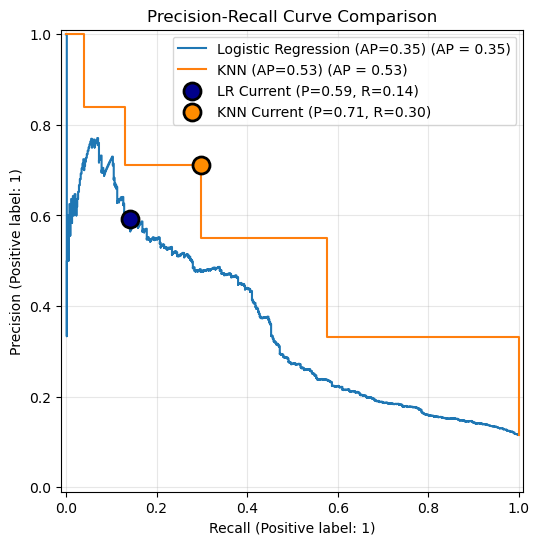

In [20]:
ap_lr = average_precision_score(y_test, lr.predict_proba(X_test)[:, 1])
ap_knn = average_precision_score(y_test, knn.predict_proba(X_test)[:, 1])

fig, ax = plt.subplots(figsize=(12,6))

PrecisionRecallDisplay.from_estimator(
    lr, X_test, y_test,
    name=f'Logistic Regression (AP={ap_lr:.2f})',
    ax=ax
)

PrecisionRecallDisplay.from_estimator(
    knn, X_test, y_test, 
    name=f'KNN (AP={ap_knn:.2f})',
    ax=ax
)

# Use different colors and add edge colors for visibility
ax.scatter(recall, precision, color='darkblue', s=150, marker='o', 
           edgecolors='black', linewidths=2,
           label=f'LR Current (P={precision:.2f}, R={recall:.2f})', zorder=5)
ax.scatter(recall_knn, precision_knn, color='darkorange', s=150, marker='o', 
           edgecolors='black', linewidths=2,
           label=f'KNN Current (P={precision_knn:.2f}, R={recall_knn:.2f})', zorder=5)

plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Baseline Model Evaluation**
- Logistic regression had higher precision than recall (over 4x) and k-NN had higher precision than recall (more than 2x). By using these models, running another telemarketing campaign can capture a segment of our clients who will leave term deposits somewhat efficiently, however we would miss a chunk of clients who would have also subscribed to more term deposits.

- Advantages of higher precision than recall are if we have budget constraints for our telemarketing campaign and want to reduce the risk of losing customers do to false positive cases. 



## **Feature Engineering**

In [21]:
# creating binary feature for job type with highest historical success rate
X_train['high_value_job'] = X_train['job'].isin(['student', 'retired']).astype(int)
# creating binary feature for previous success with client
X_train['previous_success'] = (X_train['poutcome'] == 'success').astype(int)

In [22]:
X_test['high_value_job'] = X_test['job'].isin(['student', 'retired']).astype(int)
X_test['previous_success'] = (X_test['poutcome'] == 'success').astype(int)

In [23]:
cat_feats = ['marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']
num_feats = ['age', 'balance', 'campaign', 'pdays', 'previous', 'day', 'high_value_job', 'previous_success']

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_feats)
    ]
)

lr_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

lr_2.fit(X_train, y_train)

pred_2 = lr_2.predict(X_test)
pred_proba_2 = lr_2.predict_proba(X_test)[:, 1]

In [25]:
precision_2 = precision_score(y_test, pred_2)
print(f"\nPrecision: {precision_2:.4f}")

recall_2 = recall_score(y_test, pred_2)  
print(f"\nRecall: {recall_2:.4f}")


Precision: 0.5906

Recall: 0.1440


In [26]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_feats)
    ])

knn_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

knn_2.fit(X_train, y_train)

pred_knn_2 = knn_2.predict(X_test)

In [ ]:
# Calculate precision and recall
precision_knn_2 = precision_score(y_test, pred_knn_2, pos_label=1)
recall_knn_2 = recall_score(y_test, pred_knn_2, pos_label=1)

print("=== k-NN Model Performance ===")
print(f"Precision: {precision_knn_2:.4f}")
print(f"Recall: {recall_knn_2:.4f}")

=== k-NN Model Performance ===
Precision: 0.7149
Recall: 0.3321


## **Balancing Class Distribution Models**

In [28]:
lr_balanced = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000, 
        random_state=42,
        class_weight='balanced'  # ← Automatically balances classes
    ))
])

# Train
lr_balanced.fit(X_train, y_train)

# Predict
pred_balanced = lr_balanced.predict(X_test)
pred_proba_balanced = lr_balanced.predict_proba(X_test)[:, 1]

print(f"\nPrecision: {precision_score(y_test, pred_balanced):.4f}")
print(f"Recall: {recall_score(y_test, pred_balanced):.4f}")



Precision: 0.2442
Recall: 0.5662


## **Ensembel Models**